In [1]:
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
import equinox as eqx

from flex import FuzzyVariable
from flex.train import data_batch_iterator
from flex.utils.types import Array
from flex.utils import count_parameters

In [2]:
class FNN(eqx.Module):
    input_vars: tuple[FuzzyVariable, ...]
    layers: list

    name: str = eqx.field(static=True, default="FNN")

    def __init__(
        self,
        n_in: int,
        n_out: int,
        n_mfs: int,
        n_layers: int,
        key: Array,
    ) -> None:
        keys = jax.random.split(key, n_layers + 2)

        mfs = ["triangle"] * n_mfs
        self.input_vars = tuple([FuzzyVariable.manual(mfs=mfs) for _ in range(n_in)])

        n_hidden_in = int(n_in * n_mfs)

        self.layers = [
            eqx.nn.Linear(n_hidden_in, 32, key=keys[0]),
            ]
        for i in range(n_layers):
            self.layers.append(eqx.nn.Linear(32, 32, key=keys[i+1]))

        self.layers.append(eqx.nn.Linear(32, n_out, key=keys[-1]))

    def __call__(self, x: Array) -> Array:
        x = jnp.asarray(x)

        mus = []
        for i, var in enumerate(self.input_vars):
            mus.append(var(x[i]))

        u = jnp.hstack(mus)
        for i, layer in enumerate(self.layers):
            u = layer(u)
            if i != len(self.layers) - 1:
                u = jax.nn.relu(u)

        return u

In [3]:
# Function to learn
f = lambda x, y: np.sin(x) * np.cos(y)

# Hyperparameters
N = 20000
batch_size = 1024
lr = 1e-2
epochs = 50
val_frac = 0.2
optim = optax.adam(learning_rate=lr)

# Set random seed
seed = 12345
np.random.seed(seed)

# Generate training and validation data
X = np.random.uniform(-np.pi, np.pi, size=(N, 2))
Y = f(X[:, 0], X[:, 1])

_X = (X + np.pi) / (2.0*np.pi)  # intermediate scaling of inputs

# Shuffle and enforce validation split
idx = np.random.permutation(N)
n_val = int(N * val_frac)
val_idx, train_idx = idx[:n_val], idx[n_val:]

X_train = jnp.asarray(_X[train_idx])
Y_train = jnp.asarray(Y[train_idx])
X_val = jnp.asarray(_X[val_idx])
Y_val = jnp.asarray(Y[val_idx])

In [4]:
@eqx.filter_jit
def loss_fn(model, x, y):
    m = jax.vmap(model)
    pred_y = m(x).squeeze()
    return jnp.mean((y - pred_y)**2)

@eqx.filter_jit
def step(model, x, y, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [5]:
def train(model):
    train_loss = np.zeros(epochs)
    val_loss = np.zeros(epochs)

    opt_state = optim.init(model)

    min_val = np.inf
    best_model = None

    msg = f"Starting training on {model.name}"
    print(msg)
    print("-"*len(msg))
    for epoch in range(epochs):
        x_train, y_train = next(data_batch_iterator(X_train, Y_train, batch_size, fill_batch=True))
        x_val, y_val = next(data_batch_iterator(X_val, Y_val, batch_size, fill_batch=True))

        t0 = perf_counter()
        tl, model, opt_state = step(model, x_train, y_train, opt_state)
        vl = loss_fn(model, x_val, y_val)
        dt = perf_counter() - t0

        train_loss[epoch] = tl.item()
        val_loss[epoch] = vl.item()

        if val_loss[epoch] < min_val:
            min_val = val_loss[epoch]
            best_model = model
    
        print(f"epoch {epoch+1:02d}/{epochs} | train_loss={train_loss[epoch]:.4e} | val_loss={val_loss[epoch]:.4e} took {dt:.3e} seconds")

    print(f"{model.name} Training Complete!")
    return best_model, train_loss, val_loss

In [6]:
def test(model):
    return loss_fn(model, X_val, Y_val)

In [7]:
def viz_training(title, train_loss, val_loss):
    plt.title(title)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend()
    plt.show()

In [8]:
model = FNN(2, 1, 7, 2, jax.random.PRNGKey(0))

In [9]:
best_model, train_losses, val_losses = train(model)
test_loss = test(best_model)
print(f"Test Loss = {test_loss:.4e}")

Starting training on FNN
------------------------
epoch 01/50 | train_loss=2.8931e-01 | val_loss=2.5635e-01 took 1.508e+00 seconds
epoch 02/50 | train_loss=2.6162e-01 | val_loss=2.4968e-01 took 4.147e-03 seconds
epoch 03/50 | train_loss=2.5320e-01 | val_loss=2.5346e-01 took 2.804e-03 seconds
epoch 04/50 | train_loss=2.5571e-01 | val_loss=2.5290e-01 took 2.639e-03 seconds
epoch 05/50 | train_loss=2.5488e-01 | val_loss=2.4877e-01 took 2.998e-03 seconds
epoch 06/50 | train_loss=2.5099e-01 | val_loss=2.4471e-01 took 2.165e-03 seconds
epoch 07/50 | train_loss=2.4701e-01 | val_loss=2.4083e-01 took 3.589e-03 seconds
epoch 08/50 | train_loss=2.4280e-01 | val_loss=2.3630e-01 took 3.244e-03 seconds
epoch 09/50 | train_loss=2.3723e-01 | val_loss=2.3111e-01 took 3.000e-03 seconds
epoch 10/50 | train_loss=2.3027e-01 | val_loss=2.2559e-01 took 2.300e-03 seconds
epoch 11/50 | train_loss=2.2260e-01 | val_loss=2.1887e-01 took 2.232e-03 seconds
epoch 12/50 | train_loss=2.1357e-01 | val_loss=2.1006e-01 t

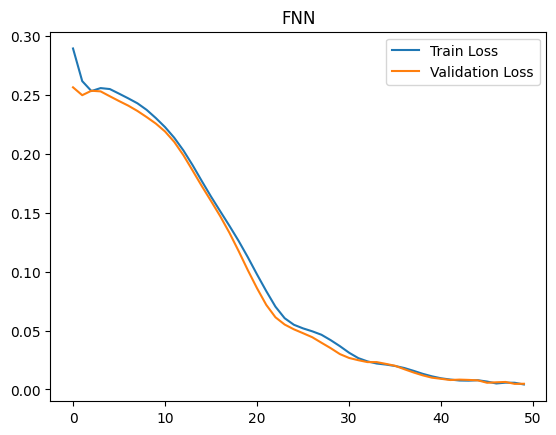

In [10]:
viz_training(model.name, train_losses, val_losses)

In [11]:
count_parameters(best_model)

2641